 **Make sure you are connecting this notebook to**
*T4 GPU*
**runtime**

##Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

root = "/content/gdrive/MyDrive"

Mounted at /content/gdrive


##Install Dependencies

Check the most updated version of ```wekzeug```, then install that version when installing dependencies.

In [2]:
!pip show werkzeug

Name: Werkzeug
Version: 3.0.1
Summary: The comprehensive WSGI web application library.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: MarkupSafe
Required-by: Flask, tensorboard


In [3]:
%%capture
!pip install segment-geospatial groundingdino-py
!pip install geopandas
!pip install -qq ipympl
!pip install leafmap
!pip install localtileserver
!pip install rasterio
!pip install werkzeug==3.0.1
!pip install flask-restx==1.2.0 localtileserver
!pip install large-image
!pip install rioxarray
!pip install rio-cogeo
# %pip install segment-geospatial groundingdino-py leafmap localtileserver
#!pip install --upgrade flask-restx

##Import Dependencies

Restart runtime.

In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
import leafmap.leafmap as leafmap
import localtileserver
from samgeo.hq_sam import SamGeo, tms_to_geotiff, get_basemaps
from samgeo import tms_to_geotiff, split_raster
from samgeo.text_sam import LangSAM
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.pyplot as plt
import re
from subprocess import run
from pathlib import Path
import rioxarray as rxr
import xarray as xr

##Process Imagery

Read in image

In [2]:
root = "/content/gdrive/MyDrive/nmeo/data_zipped"
img_dir = Path(root) / "TileFolders" / "Flight9tiles"
imgs = os.listdir(img_dir)
img_path = str(Path(img_dir) / [img for img in imgs if img.endswith("group1_7_6.tif")][0])
img_path

'/content/gdrive/MyDrive/nmeo/data_zipped/TileFolders/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6.tif'

Read in image, reproject it within GCS bounds, COG-ify

In [3]:
img = rxr.open_rasterio(img_path).squeeze()
img = img.isel(band=~(img.band == 4))
img = img.where(img != 255, 254)
# img.plot.imshow()
gcs_bounds = img.rio.transform_bounds("EPSG:4326")
img_reproj = img.rio.reproject("EPSG:4326", resolution=0.1/111111)\
    .rio.clip_box(minx=gcs_bounds[0], miny=gcs_bounds[1],
                  maxx=gcs_bounds[2], maxy=gcs_bounds[3])

out_path = Path(img_dir) / \
  re.sub(".tif", "_gcs.tif", os.path.basename(img_path))
img_reproj.rio.to_raster(out_path)

cmd = ['rio', 'cogeo', 'create', '-b', '1,2,3', out_path, out_path]
p = run(cmd, capture_output=True)
msg = p.stderr.decode().split('\n')
print(f'...{msg[-2]}')

cmd = ['rio', 'cogeo', 'validate', out_path]
p = run(cmd, capture_output = True)
msg = p.stdout.decode().split('\n')
print(f'...{msg[0]}')

...Writing output to: /content/gdrive/MyDrive/nmeo/data_zipped/TileFolders/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6_gcs.tif
.../content/gdrive/MyDrive/nmeo/data_zipped/TileFolders/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6_gcs.tif is a valid cloud optimized GeoTIFF


Show on map

In [4]:
m = leafmap.Map(zoom=15, height="800px")
m.add_basemap("SATELLITE")
m.add_raster(str(out_path), band=(1,2,3), vmax=[254,254,254], layer_name="Image")
m

INFO:large_image:Cannot use memcached for caching.


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Create Composite

In [5]:
def create_composite(input_tif, output_tif, rgb_indices):
    """Creates a color composite from the provided bands and saves as 8-bit image."""

    def scale_to_8bit(array, lower_percent=2, upper_percent=98):
        """Scales a given array to 8-bit format (0-255)."""
        p_low, p_high = np.percentile(array, (lower_percent, upper_percent))
        img_rescale = np.clip(array, p_low, p_high)
        img_rescale = ((img_rescale - p_low) / (p_high - p_low)) * 255

        # Cast to uint8
        return img_rescale.astype(np.uint8)

    with rasterio.open(input_tif) as src:
        red = src.read(rgb_indices[0])
        green = src.read(rgb_indices[1])
        blue = src.read(rgb_indices[2])

        # Scale to 8-bit for all bands
        red_8bit = scale_to_8bit(red)
        green_8bit = scale_to_8bit(green)
        blue_8bit = scale_to_8bit(blue)

        # Extract 512x512 patch from the bottom left of each band
        red_8bit_patch = red_8bit[ :512, :512]
        green_8bit_patch = green_8bit[ :512, :512]
        blue_8bit_patch = blue_8bit[ :512, :512]

        # Prepare meta data for output
        out_meta = src.meta.copy()
        out_meta.update({
            'count': 3,
            'dtype': 'uint8',
            'height': 512,
            'width': 512
        })

        with rasterio.open(output_tif, 'w', **out_meta) as dest:
            dest.write(red_8bit_patch, 1)
            dest.write(green_8bit_patch, 2)
            dest.write(blue_8bit_patch, 3)

Set In/Output

In [6]:
#input_tif_path = "/path/to/original-multispectral-tiff"
root = "/content/gdrive/MyDrive/nmeo/data_zipped/TileFolders"
input_tif_path = Path(root) / "Flight9tiles" / "flight9v2_transparent_mosaic_group1_7_6_gcs.tif"
#output_tif_path = "/path/to/output/rgb-crop-tiff"
output_tif_path = \
"/content/gdrive/MyDrive/nmeo/sam_test_imgs/output/Resort_texttest_flight9_1210"
rgb = [3,2,1]

create_composite(input_tif_path, output_tif_path, rgb)

##Add in image chip for segmentation

In [7]:
# Change this to the path to the image you want to segment.
#image = f"{root}/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6.tif"
image = input_tif_path

In [8]:
with rasterio.open(image, "r") as src:
    meta = src.meta

meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 5404,
 'height': 5046,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9.00000900000476e-07, 0.0, -71.81419831837707,
        0.0, -9.00000900000799e-07, 21.836503248429555)}

##Initialize SAM Class

From [samgeo.gishub](https://samgeo.gishub.org/examples/text_prompts/) on image segmentation using text prompts.

In [9]:
sam = LangSAM()

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:14<00:00, 173MB/s] 


In [10]:
str(image)

'/content/gdrive/MyDrive/nmeo/data_zipped/TileFolders/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6_gcs.tif'

In [11]:
sam.set_image("/content/gdrive/MyDrive/nmeo/data_zipped/TileFolders/Flight9tiles/flight9v2_transparent_mosaic_group1_7_6_gcs.tif")

Specify text prompt

In [12]:
text_prompt = "building"

Segement the image

In [13]:
sam.predict(str(image), text_prompt, box_threshold=0.24, text_threshold=0.24)

Visualize the results


1.   With bounding boxes
2.   Without bounding boxes
3. As greyscale



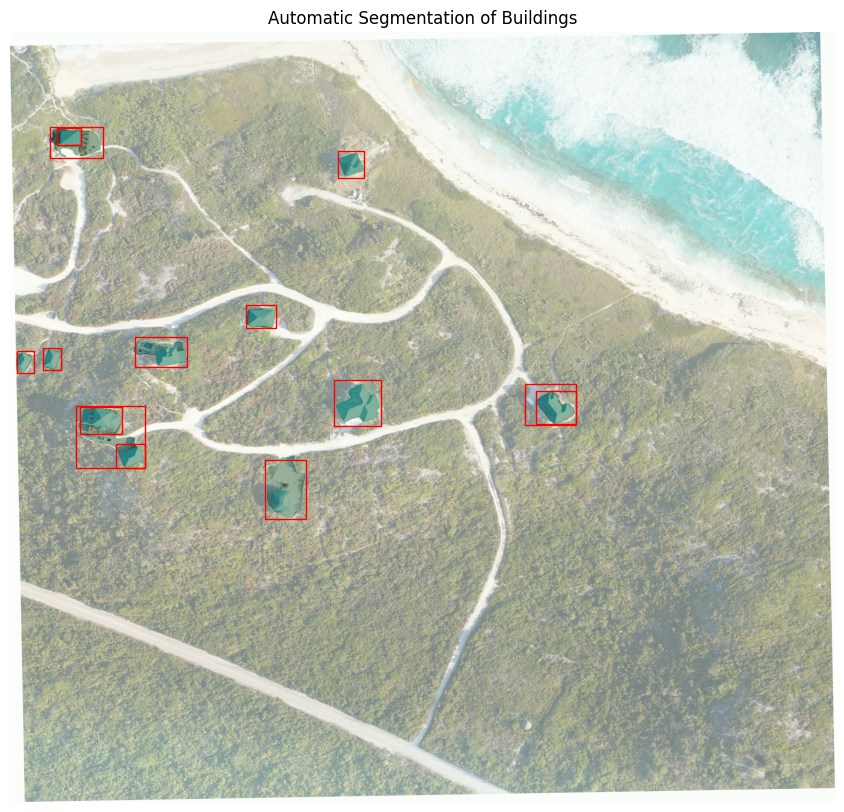

In [14]:
#with bounding boxes
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Automatic Segmentation of Buildings',
    blend=True,
)

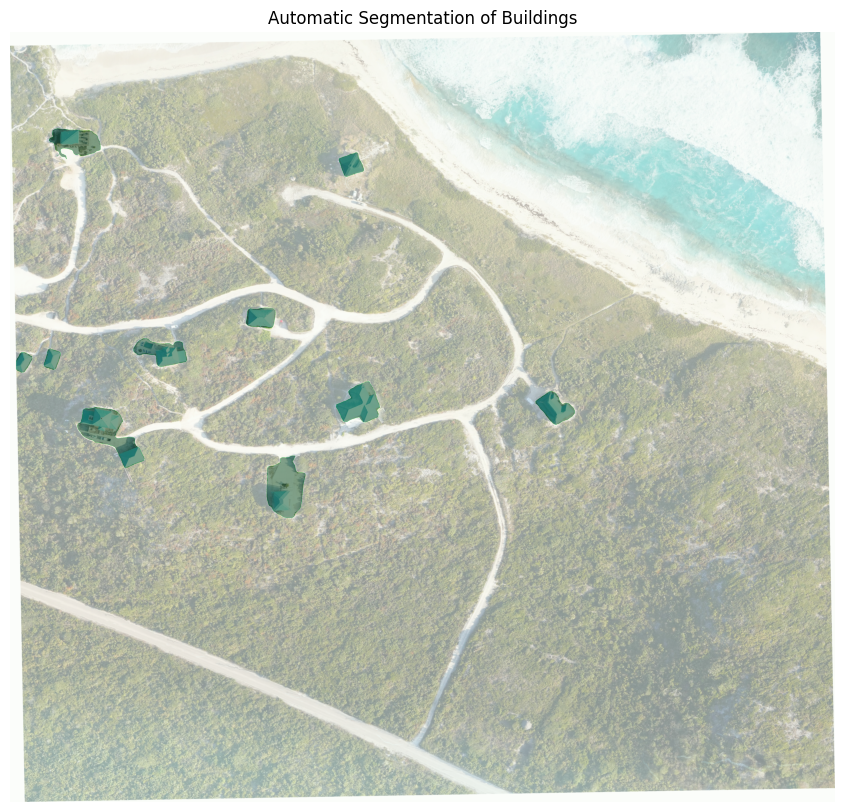

In [15]:
#without bounding boxes
sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Automatic Segmentation of Buildings',
)

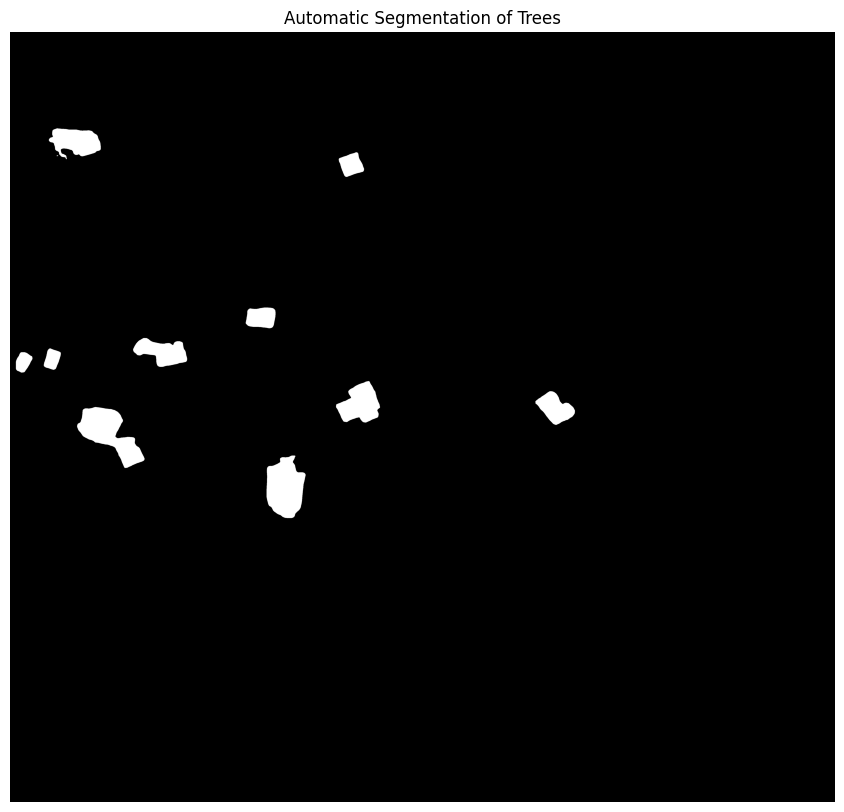

In [16]:
#as greyscale
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title='Automatic Segmentation of Trees',
    blend=False,
    output='trees.tif',
)